In [415]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [416]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [417]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data[test_data['Fare'] > 500]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
343,1235,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C


In [418]:
all_data = pd.concat([train_data, test_data])
all_data.reset_index(drop=True, inplace=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [419]:
# Fareの補完
fare = all_data.loc[(all_data['Embarked'] == 'S') & (all_data['Pclass'] == 3), 'Fare'].mean()
all_data['Fare']=all_data['Fare'].fillna(fare)

all_data.loc[(all_data['Fare'].apply(lambda x: x >= 500)) & (all_data['Survived'].isnull()), ['Sex','Age','Title']] = ['male',28.0,'Mr']
all_data.loc[(all_data['Fare'].apply(lambda x: x == 0 )) & (all_data['Survived'].isnull()), ['Sex','Age','Title']] = ['female',5.0,'Mrs']

In [420]:
from sklearn.ensemble import RandomForestClassifier

# Ageの補完
features = ['Age', 'Pclass', 'Sex', 'SibSp', 'Parch']
age_data = pd.get_dummies(all_data[features])
know_age_data = age_data[age_data['Age'].notnull()]
unknown_age_data = age_data[age_data['Age'].isnull()]

y = know_age_data['Age'].astype(int)
X = know_age_data.drop('Age', axis=1)
X_test = unknown_age_data.drop('Age', axis=1)

model = RandomForestClassifier(random_state=0, n_estimators=100, n_jobs=-1)
model.fit(X, y)
predictions = model.predict(X_test)

all_data.loc[(all_data.Age.isnull()), 'Age'] = predictions

all_data.loc[(all_data['Age'].apply(lambda x: x >= 80)) & (all_data['Survived'].isnull()), ['Sex','Age','Title']] = ['male',28.0,'Mr']

In [421]:
# Embarkedの補完
all_data['Embarked'] = all_data['Embarked'].fillna('S')

In [422]:
# Cabinの補完
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['CabinLabel'] = all_data['Cabin'].str.get(0)

In [423]:
# Aloneの追加
all_data['Family'] = all_data['SibSp'] + all_data['Parch'] + 1
all_data['Alone'] = np.where(all_data['Family'] > 1, 0, 1)

In [424]:
# Childの追加
all_data['Child'] = np.where(all_data['Age'] <= 16, 1, 0)

Survived
1.000000    113
0.000000     32
0.750000      2
0.500000      1
0.333333      1
0.142857      1
Name: count, dtype: int64
Survived
0.000000    115
1.000000     21
0.500000      6
0.333333      2
0.250000      1
Name: count, dtype: int64


<Axes: xlabel='Title', ylabel='Survived'>

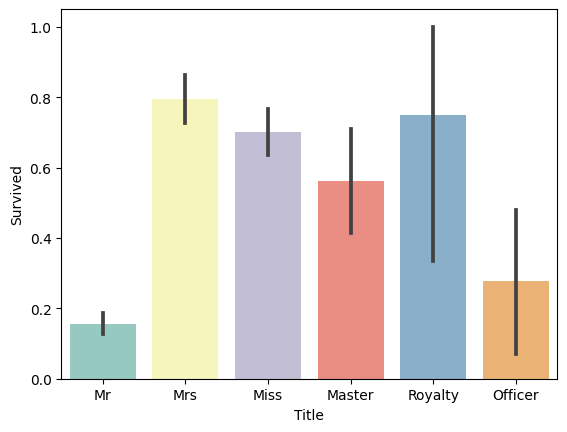

In [425]:
# Nameから特徴量を作成

# NameからSurname(苗字)を抽出
all_data['Surname'] = all_data['Name'].map(lambda name: name.split(',')[0].strip())

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
all_data['FamilyGroup'] = all_data['Surname'].map(all_data['Surname'].value_counts()) 

# 家族で16歳以下または女性の生存率
female_or_child = all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<=16) | (all_data['Sex']=='female'))]
female_or_child = female_or_child.groupby('Surname')['Survived'].mean()
print(female_or_child.value_counts())

# 家族で16歳より上かつ男性の生存率
male_and_adult = all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age']>16) & (all_data['Sex']=='male')]
male_and_adult = male_and_adult.groupby('Surname')['Survived'].mean()
print(male_and_adult.value_counts())

dead_list = set(female_or_child[female_or_child.apply(lambda x: x==0)].index)
survive_list = set(male_and_adult[male_and_adult.apply(lambda x: x==1)].index)

all_data.loc[(all_data['Surname'].apply(lambda x: x in dead_list)) & (all_data['Survived'].isnull()), ['Sex','Age','Title']] = ['male',28.0,'Mr']
all_data.loc[(all_data['Surname'].apply(lambda x: x in survive_list)) & (all_data['Survived'].isnull()), ['Sex','Age','Title']] = ['female',5.0,'Mrs']


all_data['Title'] = all_data['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
all_data['Title'] = all_data['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer')
all_data['Title'] = all_data['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty')
all_data['Title'] = all_data['Title'].replace(['Mme', 'Ms'], 'Mrs')
all_data['Title'] = all_data['Title'].replace(['Mlle'], 'Miss')
all_data['Title'] = all_data['Title'].replace(['Jonkheer'], 'Master')
sns.barplot(x='Title', y='Survived', data=all_data, palette='Set3')

In [426]:
# Ticketから特徴量作成
print(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].map(all_data['Ticket'].value_counts())
# sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')
# plt.show()

all_data.loc[(all_data['TicketGroup'] >= 2) & (all_data['TicketGroup'] <= 4), 'TicketGroup'] = 2
all_data.loc[(all_data['TicketGroup'] >= 5) & (all_data['TicketGroup'] <= 8) | (all_data['TicketGroup'] == 1), 'TicketGroup'] = 1
all_data.loc[(all_data['TicketGroup'] == 11), 'TicketGroup'] = 0

Ticket
CA. 2343        11
CA 2144          8
1601             8
PC 17608         7
S.O.C. 14879     7
                ..
113792           1
36209            1
323592           1
315089           1
359309           1
Name: count, Length: 929, dtype: int64


In [427]:
# 現在のデータの確認
all_data.info()
all_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   object 
 13  CabinLabel   1309 non-null   object 
 14  Family       1309 non-null   int64  
 15  Alone        1309 non-null   int64  
 16  Child        1309 non-null   int64  
 17  Surname      1309 non-null   object 
 18  FamilyGroup  1309 non-null   int64  
 19  Ticket

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinLabel,Family,Alone,Child,Surname,FamilyGroup,TicketGroup
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Mr,U,2,0,0,Braund,2,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,2,0,0,Cumings,2,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,U,1,1,0,Heikkinen,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,2,0,0,Futrelle,2,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,Mr,U,1,1,0,Allen,2,1


In [428]:
# 予測用データ
features = [
    'Survived',
    'Age',
    'Pclass',
#     'SibSp',
#     'Parch',
    'Fare',
    'Embarked',
    'TicketGroup',
    'Title',
    'CabinLabel',
#     'Alone',
#     'Child',
    'Family',
    'Sex',
#     'FamilyGroup'
]
sur_data = pd.get_dummies(all_data[features])

# for dataset in [sur_data]:
#     # Mapping Fare
#     dataset.loc[(dataset['Fare'] < 6), 'Fare'] = 0
#     dataset.loc[(dataset['Fare'] >= 6) & (dataset['Fare'] < 12), 'Fare'] = 1
#     dataset.loc[(dataset['Fare'] >= 12) & (dataset['Fare'] < 18), 'Fare'] = 2
#     dataset.loc[(dataset['Fare'] >= 18) & (dataset['Fare'] < 24), 'Fare'] = 3
#     dataset.loc[(dataset['Fare'] >= 24) & (dataset['Fare'] < 30), 'Fare'] = 4
#     dataset.loc[(dataset['Fare'] >= 30), 'Fare'] = 5
#     dataset['Fare'] = dataset['Fare'].astype(int)

#     # Mapping Age
#     dataset.loc[ dataset['Age'] < 13, 'Age'] = 0
#     dataset.loc[(dataset['Age'] >= 13) & (dataset['Age'] < 26), 'Age'] = 1
#     dataset.loc[(dataset['Age'] >= 26) & (dataset['Age'] < 39), 'Age'] = 2
#     dataset.loc[(dataset['Age'] >= 39) & (dataset['Age'] < 52), 'Age'] = 3
#     dataset.loc[(dataset['Age'] >= 52) & (dataset['Age'] < 65), 'Age'] = 4
#     #dataset.loc[(dataset['Age'] >= 55) & (dataset['Age'] < 65), 'Age'] = 5
#     dataset.loc[ dataset['Age'] >= 65, 'Age'] = 5 ;
#     dataset['Age'] = dataset['Age'].astype(int)

# colormap = plt.cm.RdBu
# plt.figure(figsize=(14,12))
# plt.title('Pearson Correlation of Features', y=1.05, size=15)
# sns.heatmap(sur_data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
#             square=True, cmap=colormap, linecolor='white', annot=True)

# sur_data.head()

In [429]:
# 不要なカラムを削除
drop_cols = [
    'CabinLabel_F', 
    'CabinLabel_A', 
    'CabinLabel_G', 
    'CabinLabel_T', 
    'Title_Royalty',
    'CabinLabel_C',
    'CabinLabel_B',
    'CabinLabel_D',
    'Title_Officer',
    'Embarked_Q',
#     'Alone',
    'Embarked_C',
    'Embarked_S',
]
sur_data = sur_data.drop(drop_cols, axis=1)

know_sur_data = sur_data[sur_data['Survived'].notnull()]
unknown_sur_data = sur_data[sur_data['Survived'].isnull()]

y = know_sur_data['Survived']
X = know_sur_data.drop('Survived', axis=1)

In [430]:
# パラメータ候補
is_grid_search = False

if is_grid_search:
    param_list = [
        {
            'n_estimators': ne,
            'max_depth': md,
            'random_state': rs,
        }
        for ne in [200, 250, 300, 350, 400]
        for md in [3, 4, 5, 6, 7]
        for rs in [1]
    ]
else:
    param_list = [
        {
            'n_estimators': 300,
            'max_depth': 6,
            'random_state': 1,
#             'random_state': 10, 
#             'warm_start': True,  # 既にフィットしたモデルに学習を追加 
#             'n_estimators': 26,
#             'max_depth': 4, 
#             'max_features': 'sqrt'
        }
    ]

In [431]:
# パラメータ探索
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print('Size of trainings set: {}, validation set: {}, test set: {}'.format(X_train.shape, X_valid.shape, X_test.shape))

best_score = 0
best_parameters = {}

is_select = False

if is_select:
    select = SelectKBest(k = 25)

for param in param_list:
    model = RandomForestClassifier(**param)
    if is_select:
        pipeline = make_pipeline(select, model)
        pipeline.fit(X_train, y_train)
        score = pipeline.score(X_valid, y_valid)
    else:
        model.fit(X_train, y_train)
        score = model.score(X_valid, y_valid)

    if score > best_score:
        best_score = score
        best_parameters = param

model = RandomForestClassifier(**best_parameters)
# best_parameters に対し，training set + validation set を用いて学習する
if is_select:
    pipeline = make_pipeline(select, model)
    pipeline.fit(X_trainval, y_trainval)
    # test set による評価は，best_parameters が得られて初めて行われる
    test_score = pipeline.score(X_test, y_test)
else:
    model.fit(X_trainval, y_trainval)
    test_score = model.score(X_test, y_test)
#     test_score = np.mean(cross_val_score(model, X, y))

print('Best score on cross validation: {}'.format(best_score))
print('Best parameters: {}'.format(best_parameters))
print('Test set score with best parameters: {}'.format(test_score))

if is_select:
    X_selected = select.transform(X)
    print('X.shape={}, X_selected.shape={}'.format(X.shape, X_selected.shape))

Size of trainings set: (501, 13), validation set: (167, 13), test set: (223, 13)
Best score on cross validation: 0.8203592814371258
Best parameters: {'n_estimators': 300, 'max_depth': 6, 'random_state': 1}
Test set score with best parameters: 0.8340807174887892


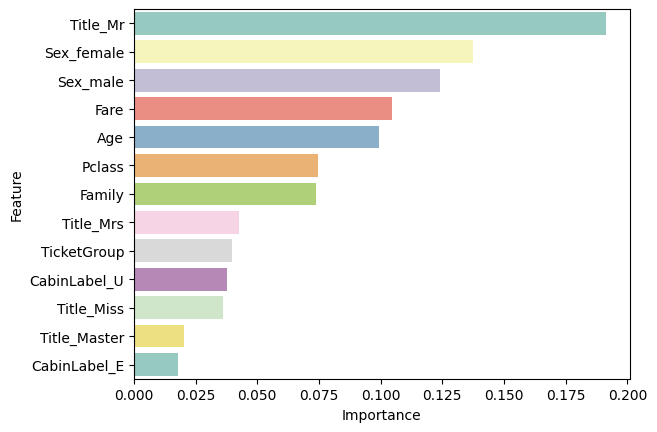

In [432]:
# 特徴量の重要度を取得
feature_importances = model.feature_importances_
features = model.feature_names_in_

# 特徴量とその重要度をDataFrameに格納
features_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# 降順にソート
features_df = features_df.sort_values(by='Importance', ascending=False)

sns.barplot(y='Feature', x='Importance', data=features_df, palette='Set3')
plt.show()

In [433]:
# Survivedの推定
X_test = unknown_sur_data.drop('Survived', axis=1)
if is_select:
    predictions = pipeline.predict(X_test)
else:
    model = RandomForestClassifier(**best_parameters)
    model.fit(X, y)
    predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions.astype(int)})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [434]:
output_data = pd.read_csv("/kaggle/working/submission.csv")
output_data.head(100)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
95,987,0
96,988,1
97,989,0
98,990,1
